In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib
#import seaborn as sns
from tqdm import tqdm 
import scipy
from scipy.interpolate import CubicSpline
from scipy import optimize
%matplotlib notebook

In [2]:
t1 = 1.0
t2 = 1.0
#def Ek(t, k):
#    E = -2*t*(np.cos(k[0]) + np.cos([k[1]]))
#    return E
def Ek(t, kx,ky):
    (xx,yy)=np.meshgrid(kx,ky)
    E = -2*t*(np.cos(xx) + np.cos(yy))
    return E

def lamb_intra(Ek, U, Del):
    l = np.sqrt( np.square( Ek ) + np.square(U*Del) )
    return l

def lamb_inter(Ek, x, Del):
    l = np.sqrt( np.square( Ek ) + np.square(x*Del) )    # x = U - J
    return l
def lamb_CDW(Ek, x, Del):
    l = np.sqrt( np.square( Ek ) + np.square(x*Del/2)) # x = (3*U - 5*J)/2
    return l
def lamb_tot(Ek, x, y, z, Del_m, Del_mm, Del_cdw ):
    l = np.sqrt( np.square( Ek ) + np.square(x*Del_m)  + np.square(y*Del_mm)  + np.square(z*Del_cdw/2) )
    # x = U
    # y = U - 2J
    # z = (3*U - 5*J)/2
    return l

## Intraorbital

In [3]:
def Delta_intra_loop(U_array,grid_Ek):
    
    Del_intra_array = np.zeros(len(U_array))
    Energy_intra_array = np.zeros(len(U_array))
    guess = 0.5
    
    for l in range(len(U_array)):
        U = U_array[l]
        for m in range(100):
            Del = 0.0
            Del = np.sum( 1.0/lamb_intra(grid_Ek, U, guess) )
            Del = -0.5*Del*U/len(grid_Ek)*guess
            if(abs(Del - guess) < 1.0E-4):
                energy_Del = 0.0
                energy_Del0 = 0.0
                
                energy_Del = - np.sum( lamb_intra(grid_Ek, U, Del) )
                energy_Del0 = - np.sum( lamb_intra(grid_Ek, U, 0) )
                        
                energy_Del = 2*( energy_Del/len(grid_Ek) - U*Del**2.0 )

                energy_Del0 = 2*( energy_Del0/len(grid_Ek) )
                if(energy_Del < energy_Del0):
                    Del_intra_array[l] = Del
                    Energy_intra_array[l] = energy_Del
                else:
                    Del_intra_array[l] = 0.0
                    Energy_intra_array[l] = energy_Del0
                break
                
            elif(m == 99):
                Del_intra_array[l] = 0.0
                
                energy_Del0 = - np.sum( lamb_intra(grid_Ek, U, 0) )
                energy_Del0 = 2*( energy_Del0/len(grid_Ek) )
                Energy_intra_array[l] = energy_Del0
                
            guess = guess*0.5 + Del*0.5
    return Del_intra_array,Energy_intra_array

In [4]:
def Delta_intra_minimize(U_array,grid_Ek):

    Del_intra_array = np.zeros(len(U_array))
    cons=({'type': 'ineq', 'fun': lambda Del: 0.5 - Del},{'type': 'ineq', 'fun': lambda Del: Del})

    for l in tqdm(range(len(U_array))):
        U = U_array[l]
    
        energy = lambda Del : 2*( - np.sum( lamb_intra(grid_Ek, U, Del)  )/(len(grid_Ek)) - U*Del**2.0 )
        a = scipy.optimize.minimize( energy , np.random.random(), method = 'SLSQP', constraints= cons )
    
            
        Del_intra_array[l] = a.x
    return Del_intra_array

In [5]:
U_array = np.r_[ -30 : 2 : 1000j ]
grid_kx = np.linspace(-np.pi, np.pi, 300, endpoint = False)
grid_ky = np.linspace(-np.pi, np.pi, 300, endpoint = False)
grid_Ek = np.zeros((len(grid_kx), len(grid_ky)))
grid_Ek=Ek(t1,grid_kx,grid_ky)

In [6]:
nb_fillings=4
Del_intra_loop=np.zeros((nb_fillings,len(U_array)))
Del_intra_opt=np.zeros((nb_fillings,len(U_array)))
for n in range(1,1+nb_fillings):
    print(n)
    Eks=np.sort(grid_Ek.flatten())
    Eks=Eks[:(len(Eks)*n)//nb_fillings]
    print('n= '+ str(2*len(Eks)/len(grid_Ek.flatten())) + ' particles per site')

    (Del_intra_loop_array,Energy_intra_loop_array)=Delta_intra_loop(U_array,Eks)
    Del_intra_opt_array=Delta_intra_minimize(U_array,Eks)
    #print(Del_intra_opt_array)
    Del_intra_opt[n-1,:]=Del_intra_opt_array
    Del_intra_loop[n-1,:]=Del_intra_loop_array

1
n= 0.5 particles per site


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 372.97it/s]


2
n= 1.0 particles per site


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 262.74it/s]


3
n= 1.5 particles per site


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 254.24it/s]


4
n= 2.0 particles per site


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 214.51it/s]


<IPython.core.display.Javascript object>


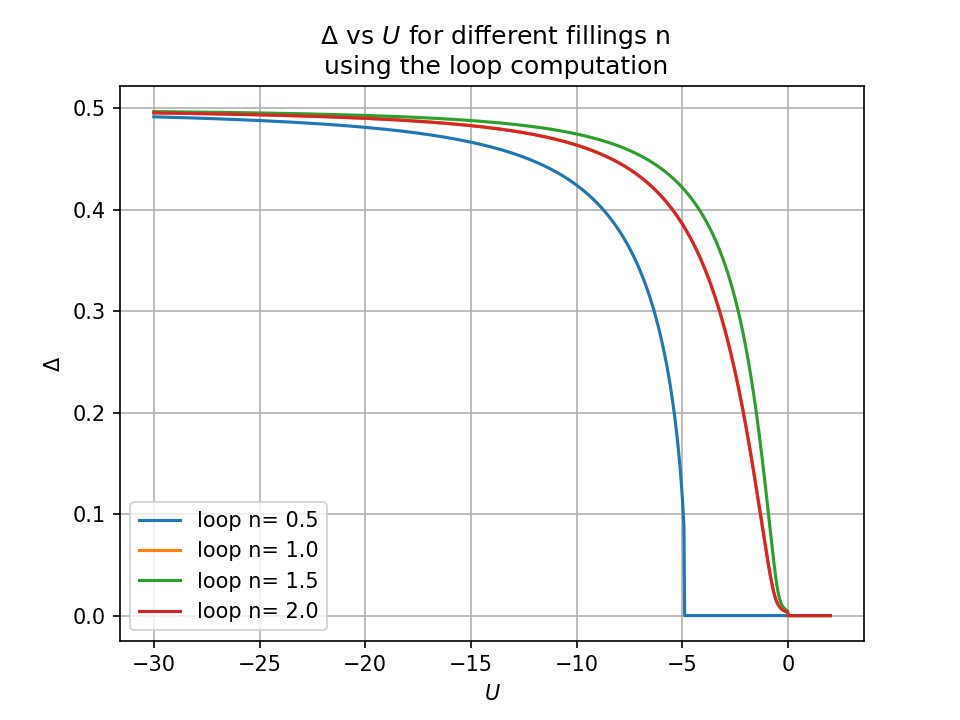

In [7]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$U$')
plt.ylabel(r'$\Delta$')
for n in range(nb_fillings):
    plt.plot(U_array, Del_intra_loop[n,:], '-',label='loop n= '+ str(2*(n+1)/nb_fillings))
#    plt.plot(U_array, Del_intra_opt[n,:], '-',label='opt n= '+ str(2*(n+1)/nb_fillings))

plt.legend()
plt.show()
plt.title(r' $\Delta$ vs $U$ for different fillings n'+'\n using the loop computation')
plt.savefig('results/intra_orbital_SC_section.png')

<IPython.core.display.Javascript object>


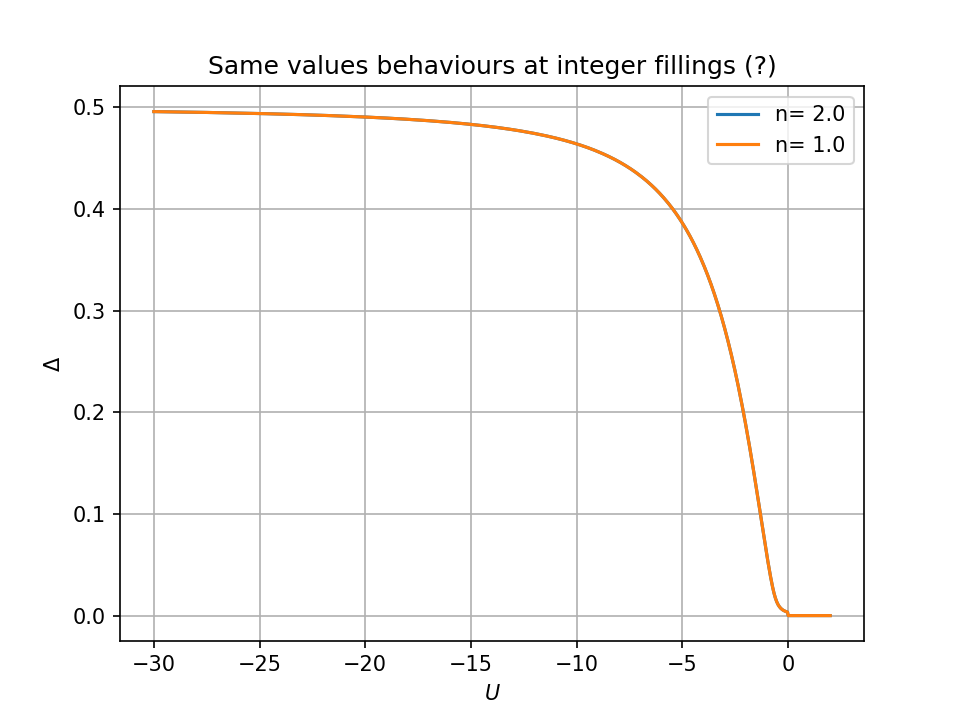

In [8]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$U$')
plt.ylabel(r'$\Delta$')
n=nb_fillings-1
plt.plot(U_array, Del_intra_loop[n,:], '-',label='n= '+ str(2*(n+1)/nb_fillings))
n=(nb_fillings-1)//2
plt.plot(U_array, Del_intra_loop[n,:], '-',label='n= '+ str(2*(n+1)/nb_fillings))

plt.legend()
plt.show()
plt.title('Same values behaviours at integer fillings (?)')
plt.savefig('results/intra_orbital_SC_section.png')

<IPython.core.display.Javascript object>


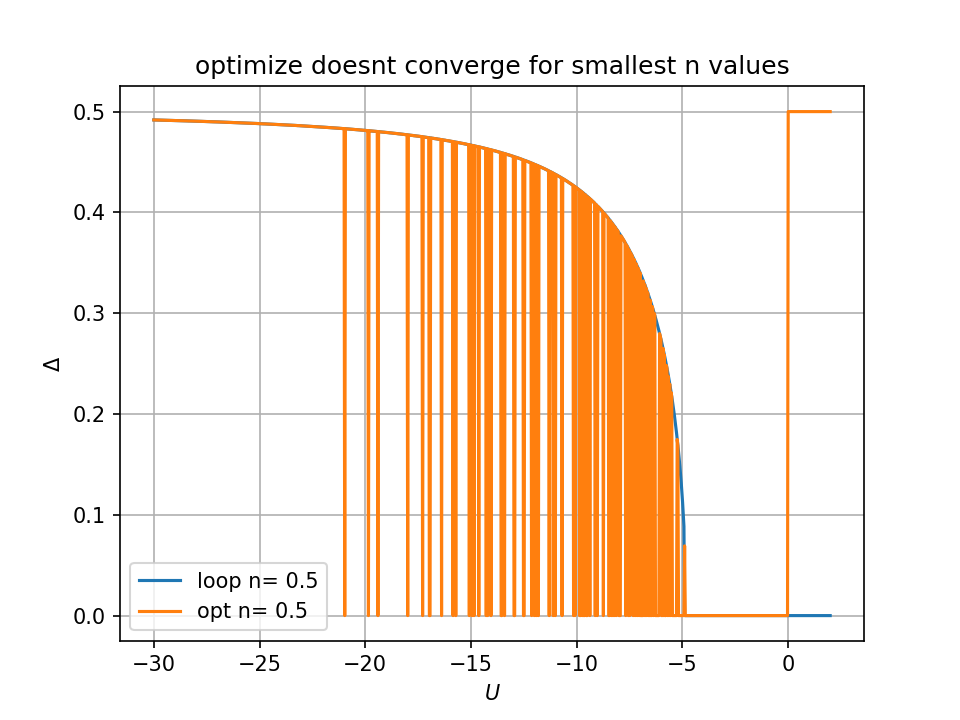

In [9]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$U$')
plt.ylabel(r'$\Delta$')
n=0
plt.plot(U_array, Del_intra_loop[n,:], '-',label='loop n= '+ str(2*(n+1)/nb_fillings))
plt.plot(U_array, Del_intra_opt[n,:], '-',label='opt n= '+ str(2*(n+1)/nb_fillings))

plt.legend()

plt.title('optimize doesnt converge for smallest n values')
#plt.show()
plt.savefig('results/intra_orbital_SC_section.png')

In [10]:
n=0
U_array = np.r_[ -30 : 2 : 1000j ]
spl = CubicSpline(U_array, Del_intra_loop[n,:] )

U_array = np.r_[ -10 : -0.000001 : 100j ]
J_array = np.r_[ -10 : 10 : 200j ]
Del_intra_array = np.zeros([len(U_array),len(J_array)])
for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        Del_intra_array[l][s] = spl(U)
        

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 496.89it/s]


<IPython.core.display.Javascript object>


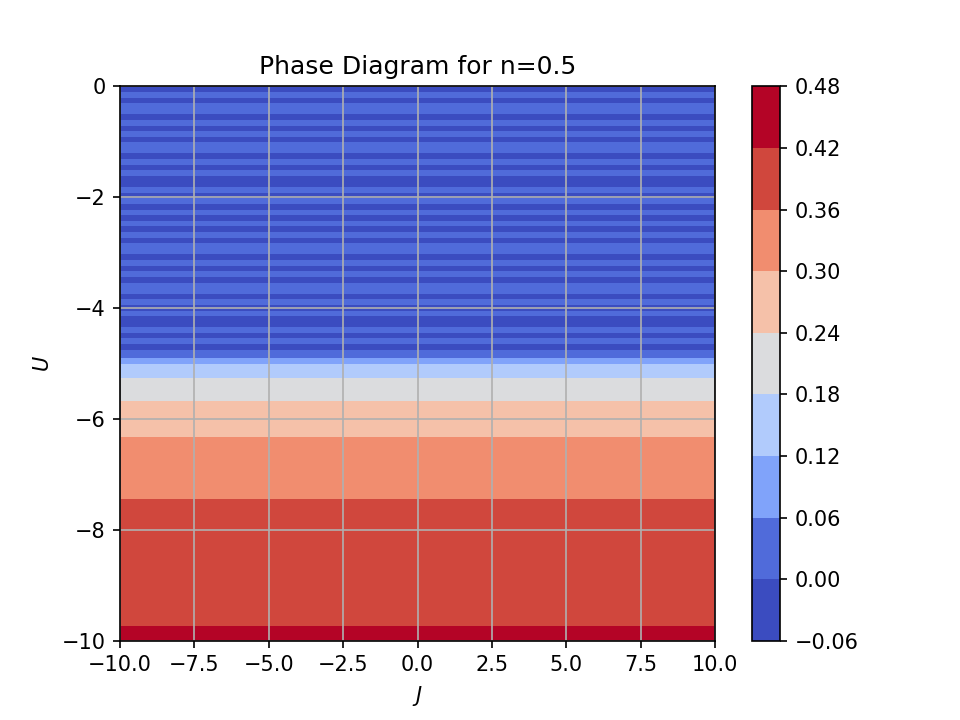

In [11]:
"""Plot of the order parameter"""
cmaps = ['viridis', 'coolwarm']

plt.figure()

vmin_Del, vmax_Del = np.min(Del_intra_array), np.max(Del_intra_array)
#plt.pcolormesh(J_array, U_array, Del_array , cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.contourf(J_array, U_array, Del_intra_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.colorbar()
plt.title(r'Phase Diagram for n='+ str(2*(n+1)/nb_fillings))
plt.grid()
plt.xlim([-10,10])
plt.ylim([-10,0])
plt.xlabel(r'$J$')
plt.ylabel(r'$U$')
#plt.show()
plt.savefig('results/intra_orbital_SC_grid.png')

# Inter-orbital SC

In [12]:
def Delta_inter_loop(x_array,grid_Ek):

    Del_inter_sec_array = np.zeros(len(x_array))
    Energy_inter_array = np.zeros(len(x_array))
    guess = 0.5

    for l in tqdm(range(len(x_array))):
        x = x_array[l]    # x = U -2*J
        for m in range(100):
            Del = 0.0
            Del = np.sum( 1.0/lamb_inter(grid_Ek, x, guess) )
            Del = -0.5*Del*x/(len(grid_Ek))*guess
            if(abs(Del - guess) < 1.0E-4):
                energy_Del = 0.0
                energy_Del0 = 0.0
            
                energy_Del = - np.sum( lamb_inter(grid_Ek, x, Del) - grid_Ek )
                energy_Del0 = - np.sum( lamb_inter(grid_Ek, x, 0) - grid_Ek )
                    
                energy_Del = 2*( energy_Del/(len(grid_Ek)) - x*Del**2.0 )
                energy_Del0 = 2*( energy_Del0/(len(grid_Ek)) )
                if(energy_Del < energy_Del0):
                    Del_inter_sec_array[l] = Del
                    Energy_inter_array[l] = energy_Del
                else:
                    Del_inter_sec_array[l] = 0.0
                    Energy_inter_array[l] = energy_Del0
                break
            elif(m == 99):
                Del_inter_sec_array[l] = 0.0
            
                energy_Del0 = - np.sum( lamb_inter(grid_Ek, x, 0)  - grid_Ek )
                energy_Del0 = 2*( energy_Del0/len(grid_Ek) )
                Energy_inter_array[l] = energy_Del0
            guess = guess*0.5 + Del*0.5
    return Del_inter_sec_array,Energy_inter_array

In [13]:
x_array = np.r_[ -30 : 20: 1000j ]
nb_fillings=4
Del_inter_loop=np.zeros((nb_fillings,len(x_array)))
for n in range(1,1+nb_fillings):
    print(n)
    Eks=np.sort(grid_Ek.flatten())
    Eks=Eks[:(len(Eks)*n)//nb_fillings]
    print('n= '+ str(2*len(Eks)/len(grid_Ek.flatten())) + ' particles per site')

    (Del_inter_loop_array,Energy_inter_loop_array)=Delta_inter_loop(x_array,Eks)
    #print(Del_intra_opt_array)
    Del_inter_loop[n-1,:]=Del_inter_loop_array

1
n= 0.5 particles per site


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1845.13it/s]


2
n= 1.0 particles per site


100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 120.93it/s]


3
n= 1.5 particles per site


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 84.82it/s]


4
n= 2.0 particles per site


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.54it/s]


<IPython.core.display.Javascript object>


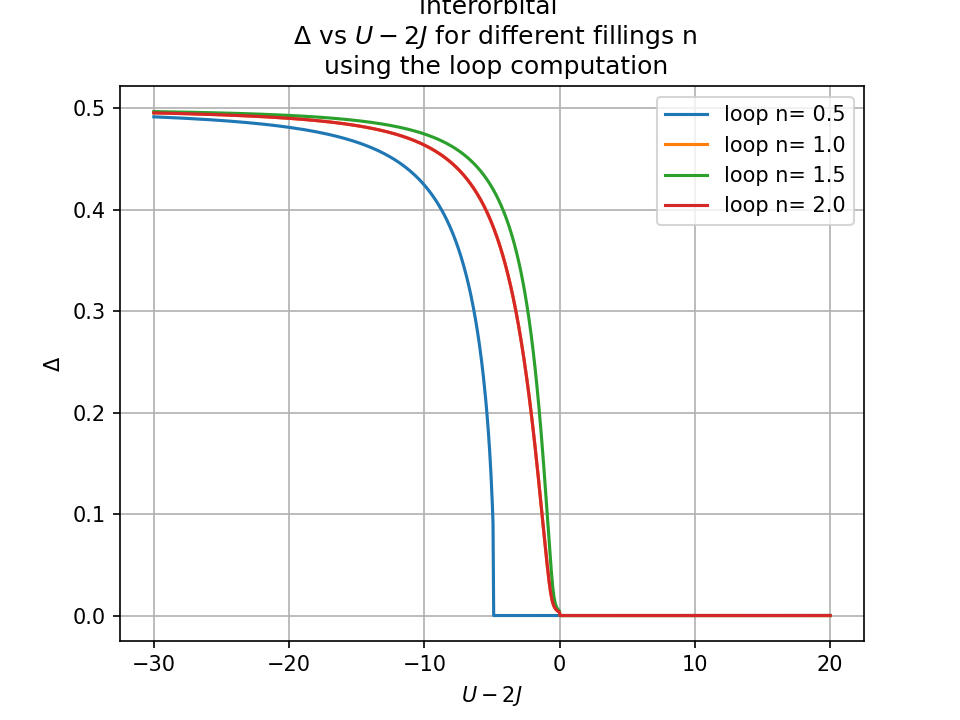

In [14]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$U-2J$')
plt.ylabel(r'$\Delta$')
for n in range(nb_fillings):
    plt.plot(x_array, Del_inter_loop[n,:], '-',label='loop n= '+ str(2*(n+1)/nb_fillings))
#    plt.plot(U_array, Del_intra_opt[n,:], '-',label='opt n= '+ str(2*(n+1)/nb_fillings))

plt.legend()
plt.show()
plt.title('interorbital \n'+r' $\Delta$ vs $U-2J$ for different fillings n'+'\n using the loop computation')
plt.savefig('results/inter_orbital_SC_section.png')

In [15]:
n=0
spl2 = CubicSpline(x_array, Del_inter_loop[n,:] )
U_array = np.r_[ -10 : -0.000001 : 100j ]
J_array = np.r_[ -10 : 10 : 200j ]
Del_inter_array = np.zeros([len(U_array),len(J_array)])

for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        x = U - 2*J
        Del_inter_array[l][s] = spl2(x)
        if (spl2(x)<10**(-3)):
            Del_inter_array[l][s] = 0.0

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 219.10it/s]


<IPython.core.display.Javascript object>


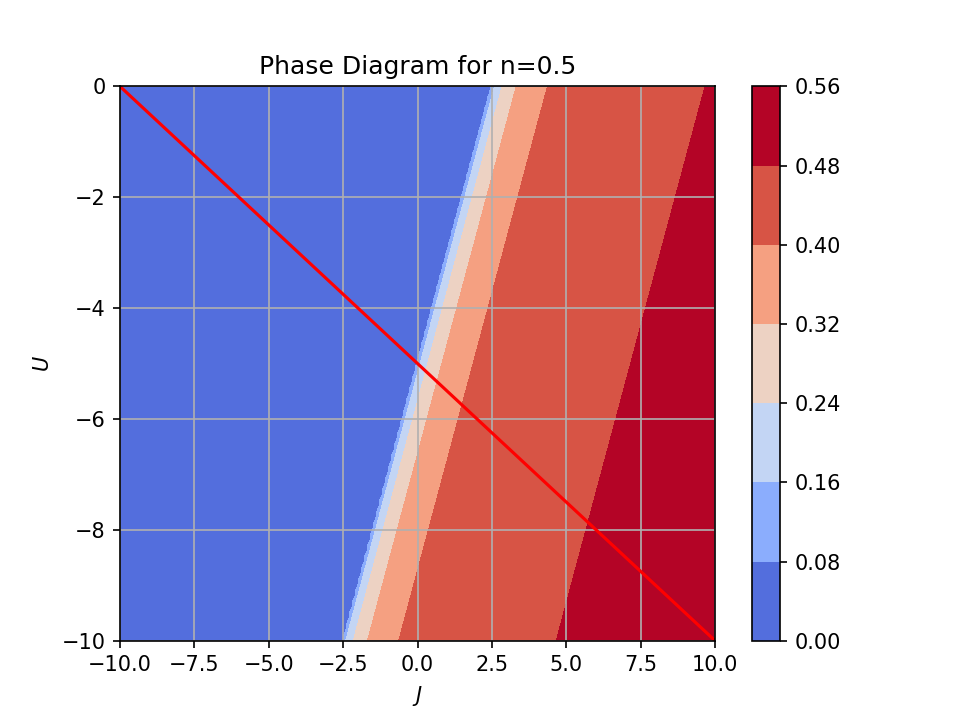

In [16]:
"""Plot of the order parameter"""
cmaps = ['viridis', 'coolwarm']
plt.figure()

vmin_Del, vmax_Del = np.min(Del_inter_array), np.max(Del_inter_array)
#plt.pcolormesh(J_array, U_array, Del_array , cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.contourf(J_array, U_array, Del_inter_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.colorbar()
plt.grid()
plt.xlim([-10,10])
plt.ylim([-10,0])
plt.xlabel(r'$J$')
plt.ylabel(r'$U$')
z = -1/2*J_array - 5
plt.plot(J_array, z, '-', color = 'red')
plt.title(r'Phase Diagram for n='+ str(2*(n+1)/nb_fillings))
#plt.show()
plt.savefig('results/inter_orbital_SC_grid.png')

## Charge Density Wave

In [17]:
gridR_kx = np.linspace(-np.pi/np.sqrt(2), np.pi/np.sqrt(2), 700, endpoint = False)
gridR_ky = np.linspace(-np.pi/np.sqrt(2), np.pi/np.sqrt(2), 700, endpoint = False)
gridR_Ek = np.zeros((len(gridR_kx), len(gridR_ky)))
gridR_Ek=Ek(t1,gridR_kx,gridR_ky)


In [18]:
def Delta_CDW_loop(x_array,grid_Ek):
    Del_CDW_sec_array = np.zeros(len(x_array))
    Energy_CDW_array = np.zeros(len(x_array))
    guess = 0.5

    for l in tqdm(range(len(x_array))):
        x = x_array[l]    # x = (3U - 5J)/2
        for m in range(100):
            
            Del = 0.0
            Del = np.sum( 1.0/lamb_CDW(grid_Ek, x, guess) )
            Del = -x*Del/(len(grid_Ek))*guess
            if(abs(Del - guess) < 1.0E-4):
                energy_Del = 0.0
                energy_Del0 = 0.0
            
                energy_Del = -2*np.sum( lamb_CDW(grid_Ek, x, Del) )
                energy_Del0 = -2*np.sum( lamb_CDW(grid_Ek, x, 0) ) 
                        
                energy_Del =  energy_Del/(len(grid_Ek)) - x*Del**2 /4 
                energy_Del0 =  energy_Del0/(len(grid_Ek))
            
                if(energy_Del < energy_Del0):
                    Del_CDW_sec_array[l] = Del
                    Energy_CDW_array[l] = energy_Del
                else:
                    Del_CDW_sec_array[l] = 0.0
                    Energy_CDW_array[l] = energy_Del0
                break

            elif(m == 99):
                Del_CDW_sec_array[l] = 0.0
            
                energy_Del0 = - 2*np.sum( lamb_CDW(grid_Ek, x, 0) )
                energy_Del0 = energy_Del0/(len(grid_Ek))
                Energy_CDW_array[l] = energy_Del0
            guess = guess*0.5 + Del*0.5
    return Del_CDW_sec_array,Energy_CDW_array

In [19]:
x_array = np.r_[ -40 : 25: 1000j ]
nb_fillings=4
Del_CDW_loop=np.zeros((nb_fillings,len(x_array)))
for n in range(1,1+nb_fillings):
    print(n)
    Eks=np.sort(gridR_Ek.flatten())
    Eks=Eks[:(len(Eks)*n)//nb_fillings]
    print('n= '+ str(2*len(Eks)/len(gridR_Ek.flatten())) + ' particles per site')

    (Del_CDW_loop_array,Energy_CDW_loop_array)=Delta_CDW_loop(x_array,Eks)
    #print(Del_intra_opt_array)
    Del_CDW_loop[n-1,:]=Del_CDW_loop_array

1
n= 0.5 particles per site


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 409.82it/s]


2
n= 1.0 particles per site


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.12it/s]


3
n= 1.5 particles per site


100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.62it/s]


4
n= 2.0 particles per site


100%|███████████████████████████████████████| 1000/1000 [01:25<00:00, 11.74it/s]


<IPython.core.display.Javascript object>


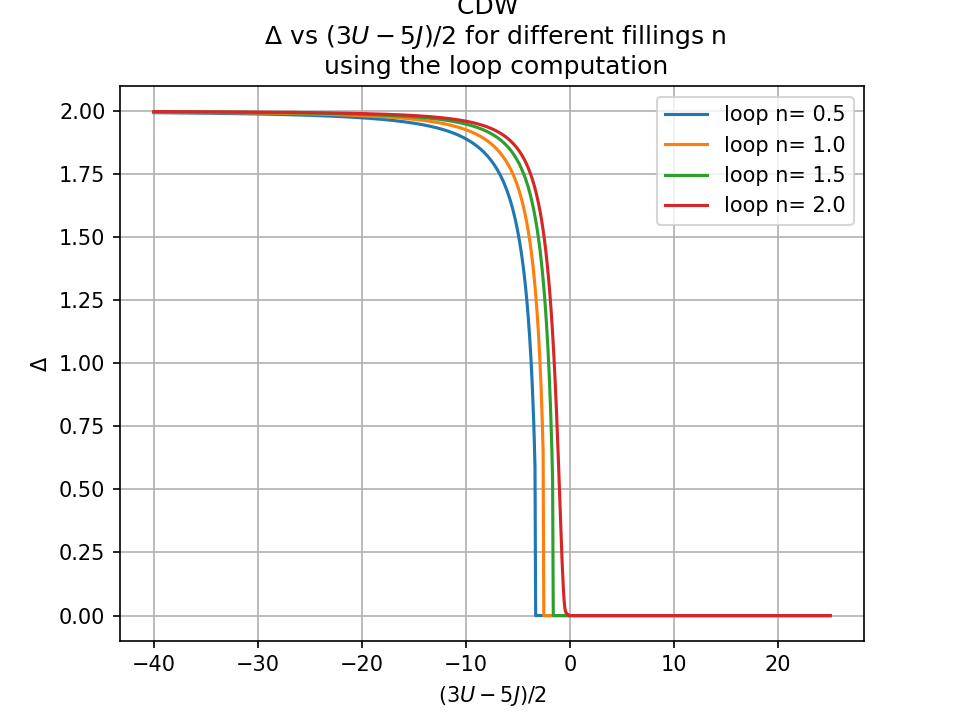

In [20]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$(3U-5J)/2$')
plt.ylabel(r'$\Delta$')
for n in range(nb_fillings):
    plt.plot(x_array, Del_CDW_loop[n,:], '-',label='loop n= '+ str(2*(n+1)/nb_fillings))
#    plt.plot(U_array, Del_intra_opt[n,:], '-',label='opt n= '+ str(2*(n+1)/nb_fillings))

plt.legend()
plt.show()
plt.title('CDW \n'+r' $\Delta$ vs $(3U-5J)/2$ for different fillings n'+'\n using the loop computation')
plt.savefig('results/inter_orbital_SC_section.png')

In [21]:
n=0
spl3 = CubicSpline(x_array, Del_CDW_loop[n,:] )
U_array = np.r_[ -10 : -0.000001 : 100j ]
J_array = np.r_[ -10 : 10 : 200j ]
Del_CDW_array = np.zeros([len(U_array),len(J_array)])

for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        x = (3*U - 5*J)/2.0
        
        if (x > 0.0):
            Del_CDW_array[l][s] = 0.0
        
        elif (x < -20.0):
            Del_CDW_array[l][s] = 2.0
        
        elif (spl3(x) < 10**(-3)):
            Del_CDW_array[l][s] = 0.0

        else:
            Del_CDW_array[l][s] = spl3(x)
        

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 521.07it/s]


<IPython.core.display.Javascript object>


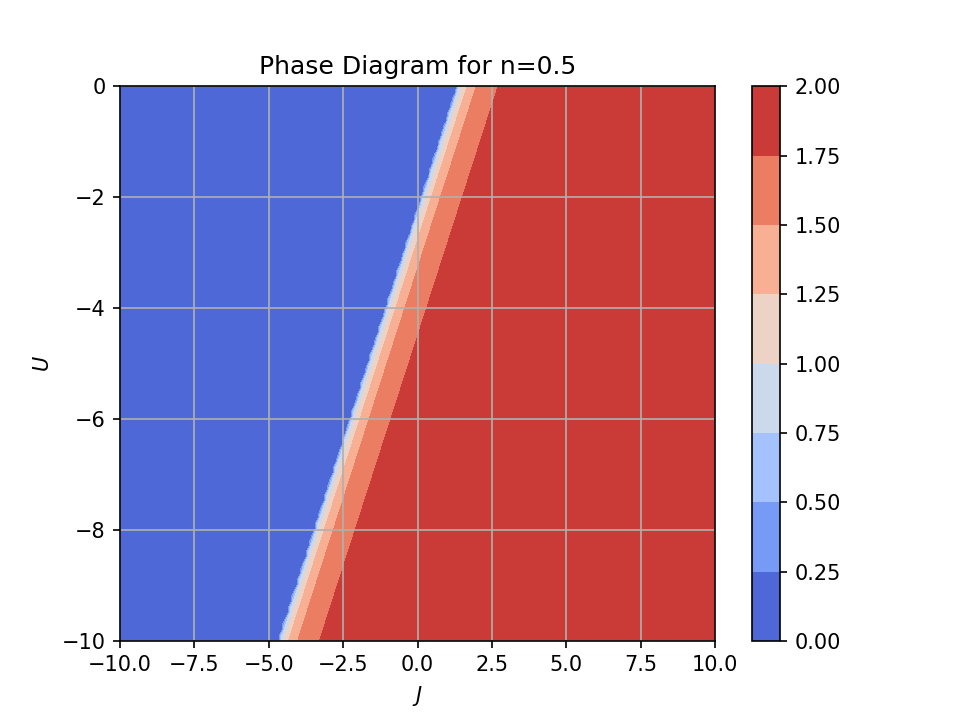

In [22]:
"""Plot of the order parameter"""
cmaps = ['viridis', 'coolwarm']

plt.figure()

vmin_Del, vmax_Del = np.min(Del_CDW_array), np.max(Del_CDW_array)
plt.contourf(J_array, U_array, Del_CDW_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.colorbar()
plt.title(r'')
plt.grid()
plt.xlim([-10,10])
plt.ylim([-10,0])
plt.xlabel(r'$J$')
plt.ylabel(r'$U$')
plt.title(r'Phase Diagram for n='+ str(2*(n+1)/nb_fillings))
#plt.plot(J_array, y, '-', color = 'black')
#plt.plot(J_array, z, '-', color = 'red')
plt.show()
#plt.savefig('results/CDW.png')